## Chapter 4 Exercises - Training Models


1. Which Linear Regression training algorithm can you use if you have a training set with millions of features? 
    - Gradient descent with lasso regression

2. Suppose the features in your training set have very different scales. Which algorithm might suffer from this and how? What can you do about it? 
    - Gradient descent will be slowed since it will preferentially follow the gradient of the feature with the larger scale first instead of taking a direct route to the minimum. 
    - feature scaling

3. Can Gradient Descent get stuck in a local minimum when training a logistic regression model? 
    - no, the cost function is convex

4. Do all gradient descent algorithms lead to the same model, provided you let them run long enough? 
    - if the learning rate is too large then an algorithm could fail to converge. 
    - if there are local minima in the cost function then one GD may get caught in the local minima while another algorithm may succesfully escape it and converge on the global mimimum or a different local minima. 
    
5. Suppose you use batch gradient descent and you plot the validation error at every epoch. If you notice the validation error consistently goes up, what is likely going on? How can you fix this? 
    - The model is getting over trained. 
    - Rollback to the model parameters at the minimum value for the validation error
    - use a simpler model
    - use a regularization technique
    - use a larger training set to reach a lower error value before overfitting occurs. 
    - If the learning rate is too high then the validation and training error will both go up.
    
6. Is it a good idea to stop mini-batch gradient descent immediately when the validation error goes up? 
    - no, in mini-batch gd the validation error will have some noise/variance from epoch to epoch. So you need to wait to see that it is consistently rising then roll back to the minimum. 
    
7. Which gradient descent alogrithm discussed will reach the viscinity of the optimal solution the fastest? Which will actually convege? How can you make others converge as well? 
    - Stochastic gradient descent will reach the right area fastest since it trains the fastest.
    - Batch gradient descent will converge on the actual optimal solution eventually
    - applying a good learning schedule to modulate the learning rate over the course of training can allow stochastic and mini-batch GD to converge. 
    
8. Suppose you are using polynomial regression. You plot the learning curves and you notice there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?
    - the gap means that the model is performing better on the training data vs the validation data. This means the model is overfitting the to the training data. 
    - You could use a simpler model such as linear regression or reduce the number of degress in your polynomial regression. 
    - You could regulate the cost function with ridge regression or lasso. Will reduce complexity by eliminating weights of unimportant features.  
    - You could provide a large training dataset to allow the model to train longer before it becomes over fit. 
    
9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter alpha or reduce it? 
    - the model has high bias since it seems to generalize well to the validation data but have poor performance. 
    - you should reduce alpha to trend more towards variance in the bias variance trade off. This will necessarily increase the variance, but if you manage to reduce the error enough before the variance rises to an unacceptable level then you may fix the problem. 
    
10. Why would you want to use:
    - Ridge Regression? Ridge regression will help to reduce the model's variance and generalize better to new data. It prevents overfitting.
    - Lasso instead of Ridge Regression? Lasso regression is useful if you suspect that many of your features are not important. Lasso will reduce the weights of unimportant features to zero or near zero. 
    - Elastic Net instead of Lasso?  If you have more features than instances in your training data then you should use elastic net
    
11. Suppose you want to classify pictures as outdoor/indoor and daytime/nightime. Should you implement two logistic regression classifiers or one softmax regression classifier? 
    - Since each picture will have up to two classes represented (daytime and outdoor or nightime and inside in the same pic) you should use two logistic regression classifiers. Although telling night from day indoors seems like it might be impossible any room without windows. 
    

##  12. Implement Batch Gradient Descent with early stopping for softmax regression without using scikitlearn. 

In [20]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))

X = iris["data"]
y = iris["target"]
print(X.shape)
print(y.shape)

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']
(150, 4)
(150,)


In [22]:
def unison_shuffled_copies(target, data):
    assert len(target) == len(data)
    p = np.random.permutation(len(target))
    return target[p], data[p,:]

In [23]:
def train_val_test_split(in_data, val_precent, test_percent):
    #in_data is the data to be split into training test and validation sets. 2D array
    #val_precent is the percentage (0:1) of the data to use for validation. scaler value
    
    val_n = int(np.round(in_data.shape[0] * val_percent))
    test_n = int(np.round(in_data.shape[0] * test_percent))
    train_n = int(in_data.shape[0] - (test_n + val_n))
    
    if in_data.ndim == 2:
        train_data = in_data[:train_n,:]
        val_data = in_data[np.arange(train_n,(train_n+val_n)),:]
        test_data = in_data[(train_n+val_n)::,:]
    elif in_data.ndim == 1:
        train_data = in_data[:train_n]
        val_data = in_data[np.arange(train_n,(train_n+val_n))]
        test_data = in_data[(train_n+val_n)::]
    
    return train_data, val_data, test_data
    

In [24]:
def one_hot_func(target, n_classes):
    
    #make a zero array of size (samples by classes)
    one_hot_target = np.zeros((len(target), n_classes))
    #populate the array with one value per sample 
    one_hot_target[[range(0,len(target))],[target]] = 1
    
    return one_hot_target

In [36]:
#calculate the model predictions and class probability for each instance
def softmax_predict(theta, X):
    # X is instance by features   
    #theta is  features by classes
    #class_score is instance by classes
    #prob_of_k  size instances x classes
    #model_preds len = # instances

    #claclulate the score for each instance for each class using current model
    class_score = X.dot(theta)
    
    #find the model's class prediction for each instance
    model_preds = np.argmax(class_score, axis=1)
    
    #use softmax function to estimate probability that each instance belongs to class k
    #class_score -= class_score.max()
    class_exps = np.exp(class_score)
    prob_of_k = class_exps / np.sum(class_exps, axis=1)[:,None]
        
    return model_preds, prob_of_k

In [26]:
#preprocessing

if 'iris' in locals():
    #feature scaling (iris) 
    X_scaled = (X-X.mean(axis=0)) / X.std(axis=0)
elif 'mnist' in locals():
    #normalize (mnist)
    X_scaled = X / np.max(X)

#sample shuffle
y, X_scaled = unison_shuffled_copies(y, X_scaled)

#add in the bias term
X_scaled = np.c_[np.ones([len(X_scaled), 1]), X_scaled]

#make a one-hot target array
n_classes = len(np.unique(y))
y_oh = one_hot_func(y, n_classes)

#train/validation split
val_percent = 0.2
test_percent = 0.2
X_train, X_val, X_test = train_val_test_split(X_scaled, val_percent, test_percent)
y_train, y_val, X_test = train_val_test_split(y, val_percent, test_percent)
y_train_oh, y_val_oh, X_test_oh = train_val_test_split(y_oh, val_percent, test_percent)


In [37]:
eta = 0.1 #learning rate
epsilon = 1e-7
n_iterations = 50000
m_train = len(y_train)
m_val = len(y_val)
min_val_loss = float("inf")
best_epoc = None
best_model = None

n_features = X_train.shape[1]
k_classes = len(np.unique(y))
theta = np.random.rand(n_features,k_classes) # need one of these for each class
xentr_val = np.array([])
xentr_train = np.array([])


In [42]:
5+ \
5

10

In [39]:
for iteration in range(n_iterations): 
     
    #get probabilities for each class and predictions of the model
    model_preds, prob_of_k = softmax_predict(theta, X_train)
    model_preds_val, prob_of_k_val = softmax_predict(theta, X_val)
    
    #calculate errors to evaluate early stopping
    cross_entr_train = -(1/m_train) * np.sum(y_train_oh*(np.log(prob_of_k)))
    cross_entr_val = -(1/m_val) * np.sum(y_val_oh*(np.log(prob_of_k_val)))
    xentr_train = np.append(xentr_train, cross_entr_train)
    xentr_val = np.append(xentr_val, cross_entr_val)
    
    #evaluate model performance and continue or stop training 
    if min_val_loss > cross_entr_val:
        min_val_loss = cross_entr_val
        best_epoc = iteration
        best_model = theta
        
    #Early Stopping
    if cross_entr_val > min_val_loss:
        print('minimum validation error reached on iteration: ' + str(iteration))
        break
    
    #calculate the gradient veector for each class (gradient array)
    gradients = (1/m_train) * X_train.T.dot(prob_of_k - y_train_oh) #features by class
    
    #update the model
    theta = theta - eta*gradients
    
    #reporting
    if iteration % 500 == 0:
        print('iteration: ' + str(iteration) + ' training error: ' + str(cross_entr_val))
    elif iteration == n_iterations-1:
        print('done')


iteration: 0 training error: 0.9652277278271285
iteration: 500 training error: 0.22450999159652116
iteration: 1000 training error: 0.18321903963368122
iteration: 1500 training error: 0.16647837776271804
iteration: 2000 training error: 0.15748098675316435
iteration: 2500 training error: 0.15187180301366243
iteration: 3000 training error: 0.14804187900348087
iteration: 3500 training error: 0.14526171960655287
iteration: 4000 training error: 0.14315321762794114
iteration: 4500 training error: 0.14150097032370756
iteration: 5000 training error: 0.14017331137945885
iteration: 5500 training error: 0.13908524160512625
iteration: 6000 training error: 0.13817943941567218
iteration: 6500 training error: 0.1374158400864483
iteration: 7000 training error: 0.13676558990781268
iteration: 7500 training error: 0.13620737348987924
iteration: 8000 training error: 0.13572509478342965
iteration: 8500 training error: 0.13530636379346395
iteration: 9000 training error: 0.13494148056064656
iteration: 9500 tr

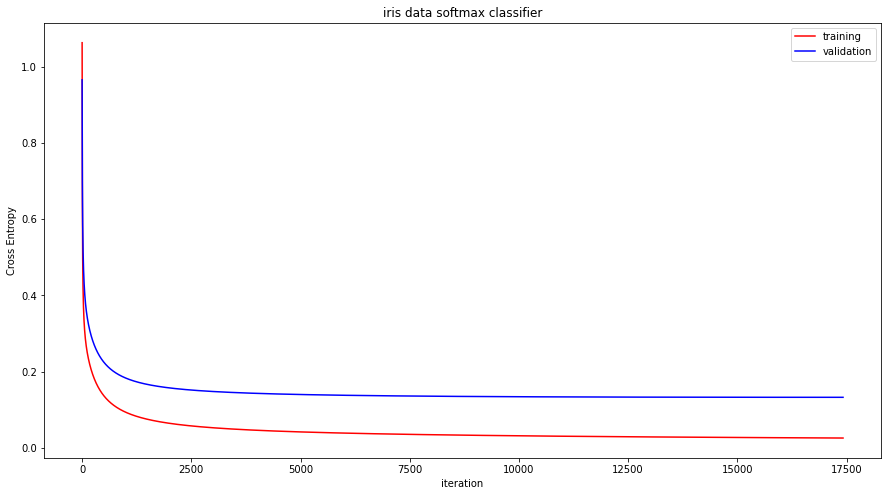

In [40]:
fig = plt.figure(figsize=(15,8))
plt.plot(range(0, len(xentr_train)), xentr_train, color='r', label='training')
plt.plot(range(0, len(xentr_val)), xentr_val, color='b', label='validation')
plt.title('iris data softmax classifier')
plt.ylabel('Cross Entropy')
plt.xlabel('iteration')
plt.legend()
plt.show()
